In [3]:
import jax

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

from flax import linen as nn
from flax.training import train_state

from tqdm import trange
from functools import partial

In [4]:
from typing import NamedTuple, Any
import math
import numpy as np
from matplotlib import pyplot as plt

class TimedX(NamedTuple):
  t: Any
  x: Any

def gaussians(key, t):
  bs = t.shape[0]
  keys = random.split(key, 3)
  x_1 = random.randint(keys[0], minval=0, maxval=2, shape=(bs, 2))
  x_1 = x_1.astype(np.float32)-0.5
  x_1 += 1e-1*random.normal(keys[1], shape=(bs,2))
  x_0 = 1e-1*random.normal(keys[2], shape=(bs,2))
  return (1-t)*x_0 + t*x_1

def diamonds(key, t):
  bs = t.shape[0]
  keys = random.split(key, 3)
  x_1 = random.randint(keys[0], minval=0, maxval=2, shape=(bs, 2))
  x_1 = x_1.astype(np.float32)-0.5
  x_1 += 5e-1*(random.uniform(keys[1], shape=(bs,2))-0.5)
  x_0 = 5e-1*(random.uniform(keys[2], shape=(bs,2))-0.5)
  x_t = (1-t)*x_0 + t*x_1
  R = jnp.array([[1/math.sqrt(2),-1/math.sqrt(2)],
                 [1/math.sqrt(2),1/math.sqrt(2)]])
  return x_t@R 

def sinusoid(key, t):
  mean = jnp.hstack([t-1.0, 1.0*jnp.sin(2*math.pi*t)])
  return 1e-1*random.normal(key, shape=(bs,2)) + mean

# DEFINE THE DYNAMICS TO USE HERE
q_t = diamonds

############################## plotting utils ##############################

def plot_dynamics(dynamics, label, axes=None):
  n_cols = len(dynamics)
  if axes is None:
    _, axes = plt.subplots(1, n_cols, figsize = [24,4])
  for i in range(n_cols):
    t = dynamics[i].t
    x_t = dynamics[i].x

    axes[i].scatter(x_t[:,0], x_t[:,1], alpha=0.7, label=f'{label} (t={t:.2f})')
    axes[i].legend(loc='upper right', fontsize=8)
    axes[i].set_xlim(-1.5,1.5)
    axes[i].set_ylim(-1.5,1.5)
    axes[i].set(frame_on=False, yticklabels=[], xticklabels=[])
    axes[i].grid(True)
  return axes

In [5]:
seed = 0
np.random.seed(seed)
key = random.PRNGKey(seed)
bs = 512
t_axis = np.linspace(0.0, 1.0, 6)
x_t = []
for t in t_axis:
  key, loc_key = random.split(key)
  x_t.append(TimedX(t=t, x=q_t(loc_key, t*np.ones([bs,1]))))

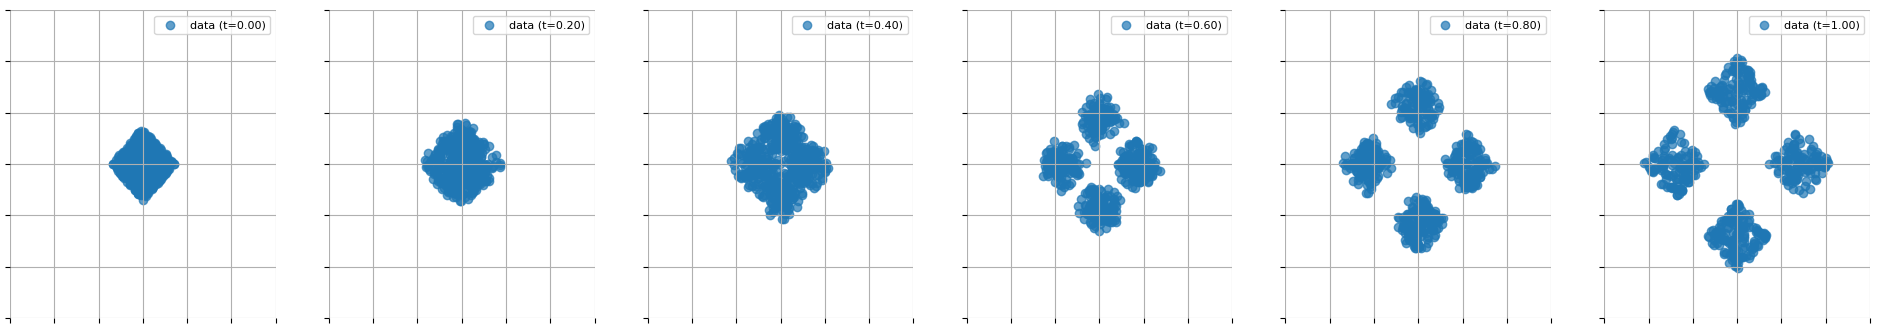

In [6]:
import matplotlib.pyplot as plt

plot_dynamics(x_t, 'data')
plt.show()

In [7]:
class MLP(nn.Module):
  num_hid : int
  num_out : int

  def setup(self):
    self.proj_x = nn.Dense(features=self.num_hid)
    self.proj_x0 = nn.Dense(features=self.num_hid)
    self.proj_t = nn.Dense(features=self.num_hid)
    self.linear1 = nn.Dense(features=self.num_hid)
    self.linear2 = nn.Dense(features=self.num_hid)
    self.linear3 = nn.Dense(features=self.num_hid)
    self.linear4 = nn.Dense(features=self.num_out)

  def __call__(self, t, x, x0):
    # h = jnp.hstack([t,x])
    # h = self.linear1(h)
    h = self.proj_t(t)  + self.proj_x(x) 
    h = nn.elu(h)
    h = self.linear2(h)
    h = nn.elu(h)
    h = self.linear3(h)
    h = nn.elu(h)
    h = self.linear4(h)
    return h

class PotentialMLP(nn.Module):
  num_hid : int
  num_out : int = 1

  def setup(self):
    self.linear1 = nn.Dense(features=self.num_hid)
    self.linear2 = nn.Dense(features=self.num_hid)
    self.linear3 = nn.Dense(features=self.num_hid)
    self.linear4 = nn.Dense(features=self.num_out)

  def __call__(self, x):
    h = self.linear1(x)
    h = nn.relu(h)
    h = self.linear2(h)
    h = nn.swish(h)
    h = self.linear3(h)
    h = nn.swish(h)
    h = self.linear4(h)
    return h



In [26]:
import optax
model = MLP(num_hid=256, num_out=1)
# potential_model = PotentialMLP(num_hid=128, num_out=1)
print(model)

key, init_key, potential_model_key = random.split(key, 3)
params = model.init(init_key, x_t[0].t*np.ones([bs,1]), x_t[0].x, x_t[0].x)
# params_potential = potential_model.init(potential_model_key, x_t[-1].x)

num_iterations = 100_001
lr_schedule = optax.cosine_decay_schedule(
    init_value=5e-4, decay_steps=num_iterations, alpha=1e-2
)
optimizer = optax.adam(learning_rate=lr_schedule)
# optimizer_potential = optax.adam(learning_rate=5e-5)

state = train_state.TrainState.create(apply_fn=model.apply,
                                      params=params,
                                      tx=optimizer)
# state_potential = train_state.TrainState.create(apply_fn=potential_model.apply,
#                                       params=params_potential,
#                                       tx=optimizer_potential)



MLP(
    # attributes
    num_hid = 256
    num_out = 1
)


In [27]:
from ott.geometry import costs

dsdtdx_fn = jax.grad(lambda p, t, x, x0: state.apply_fn(p,t,x,x0).sum(), argnums=[1,2])
dsdx_fn = jit(jax.grad(lambda p, t, x, x0: state.apply_fn(p,t,x,x0).sum(), argnums=2))


def sample_t(u0, n, t0=0.0, t1=1.0):
  u = (u0 + math.sqrt(2)*np.arange(n + 1)) % 1
  u = u.reshape([-1,1])
  return u[:-1]*(t1-t0) + t0, u[-1]


def expectile_loss(diff: jnp.ndarray, expectile=0.98) -> jnp.ndarray:
    weight = jnp.where(diff >= 0, expectile, (1 - expectile))
    return weight * diff ** 2


def am_loss(state, params, bs, u0, key):
  keys = random.split(key)
  
  t, u0 = sample_t(u0, bs)
  t_0, t_1 = jnp.zeros([bs, 1]), jnp.ones([bs, 1])
  x_0, x_1 = q_t(keys[0], t_0), q_t(keys[1], t_1)
  x_t = x_0 * (1 - t) + x_1 * t

  dsdt, dsdx = dsdtdx_fn(params, t, x_t, x_0)
  s_diff = (dsdt - 0.5 * (dsdx**2).sum(1, keepdims=True))
  loss = (s_diff ** 2).mean() + 0.05 * jnp.abs(s_diff).mean() 

  return loss, u0

def potential_loss(state, params, key, bs, steps_count, weight):
  keys = random.split(key)
  t_0, t_1 = jnp.zeros([bs, 1]), jnp.ones([bs, 1])
  x_0, x_1 = q_t(keys[0], t_0), q_t(keys[1], t_1)
  dt = 1.0 / steps_count

  def step_fn(carry, _):
    t_, x_ = carry
    dsdx = dsdx_fn(state.params, t_, x_, x_0)
    x_ = x_ - dt * dsdx
    t_ = t_ + dt
    return (t_, x_), x_
  
  _, result = jax.lax.scan(step_fn, (t_0, x_0), None, length=steps_count)
  x_1_pred = jax.lax.stop_gradient(result[-1])

  dual_loss = - (-state.apply_fn(params, t_1, x_1, x_0 * 0) + state.apply_fn(params, t_1, x_1_pred, x_0 * 0)).mean()

  # exp. reg

  source, target = x_0, x_1
  target_hat_detach = x_1_pred
  batch_cost = lambda x, y: 0.5 * jax.vmap(costs.SqEuclidean())(jnp.atleast_2d(x), jnp.atleast_2d(y)).reshape(-1)
  g_target = -state.apply_fn(params, t_1, x_1, x_0 * 0).reshape(-1)
  g_star_source = batch_cost(source, target_hat_detach) + state.apply_fn(params, t_1, x_1_pred, x_0 * 0).reshape(-1)

  diff_1 = jax.lax.stop_gradient(g_star_source - batch_cost(source, target))\
    + g_target
  reg_loss_1 = expectile_loss(diff_1).mean()

  diff_2 = jax.lax.stop_gradient(g_target - batch_cost(source, target))\
    + g_star_source
  reg_loss_2 = expectile_loss(diff_2).mean()

  reg_loss = (reg_loss_1 + reg_loss_2) * 0.5

  return (reg_loss + dual_loss)  * weight

@partial(jax.jit, static_argnums=(1,))
def train_step_cost(state, bs, u0, key):
  grad_fn = jax.value_and_grad(am_loss, argnums=1, has_aux=True)
  (loss, u0), grads = grad_fn(state, state.params, bs, u0, key)
  state = state.apply_gradients(grads=grads)
  
  return state, loss, u0


@partial(jax.jit, static_argnums=(1,))
def train_step_with_potential(state, bs, u0, key):
  grad_fn = jax.value_and_grad(am_loss, argnums=1, has_aux=True)
  (loss, u0), grads = grad_fn(state, state.params, bs, u0, key)
  state = state.apply_gradients(grads=grads)
  
  grad_fn = jax.value_and_grad(potential_loss, argnums=1, has_aux=False)
  loss_potential, potential_grads = grad_fn(state, state.params, key, bs, 30, 5)
  state = state.apply_gradients(grads=potential_grads)
  
  return state, loss, loss_potential, u0

key, loc_key = random.split(key)
state, loss, loss_potential, u0 = train_step_with_potential(state, bs, 0.5, loc_key)

100000 0.00026955904 0.014086448 [0.7316284]


100%|██████████| 30/30 [00:00<00:00, 412.81it/s]


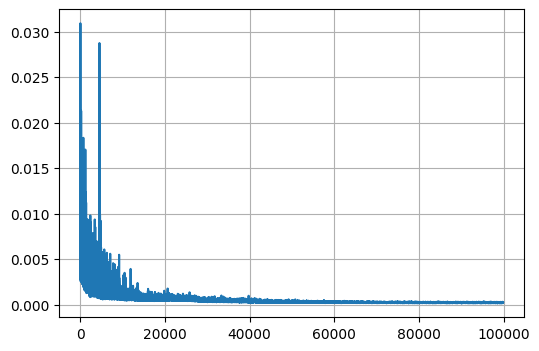

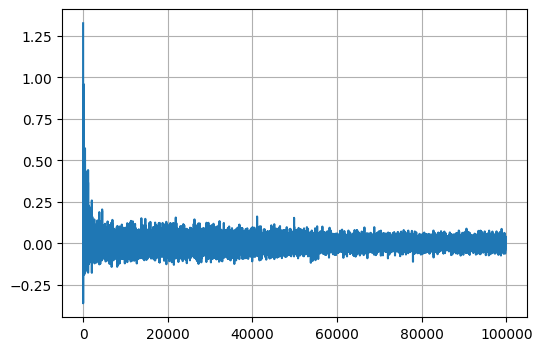

<Figure size 2500x600 with 0 Axes>

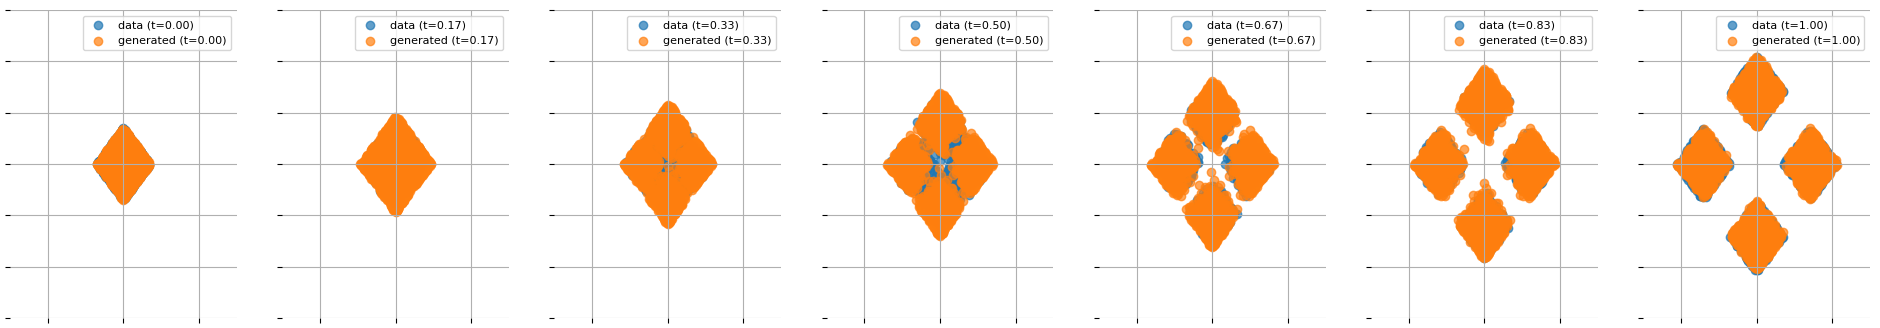

100%|██████████| 100001/100001 [02:27<00:00, 679.40it/s]

Sinkhorn distance between target predictions and data samples: 0.08023
L2 distance between target predictions and source: 0.14780
Sinkhorn distance between source and target data: 0.14770
Path cost: 0.14890


In [28]:

u0 = 0.5

loss_plot = np.zeros(num_iterations)
loss_potential_plot = np.zeros(num_iterations)
key, loop_key = random.split(key)

from IPython.display import clear_output, display
from ott.tools import sinkhorn_divergence
from ott.geometry import costs, pointcloud


@jax.jit
def sinkhorn_loss(
    x: jnp.ndarray, y: jnp.ndarray, epsilon: float = 0.001
) -> float:
    """Computes transport between (x, a) and (y, b) via Sinkhorn algorithm."""
    a = jnp.ones(len(x)) / len(x)
    b = jnp.ones(len(y)) / len(y)

    sdiv = sinkhorn_divergence.sinkhorn_divergence(
        pointcloud.PointCloud, x, y, epsilon=epsilon, a=a, b=b
    )
    return sdiv.divergence

def inference(state):
  test_bs = 2000
  key = random.PRNGKey(0)
  dt = 1.0 / 30
  t_0 = 0.0
  n = 30
  key, *keys = random.split(key, num=3)
  x = [TimedX(t=t_0, x=q_t(keys[0], t_0*np.ones([test_bs,1])))]
  true_x = [TimedX(t=t_0, x=q_t(keys[1], t_0*np.ones([test_bs,1])))]

  cost = 0

  for _ in trange(n):
    u = dsdx_fn(state.params, x[-1].t*np.ones([test_bs,1]), x[-1].x, x[0].x)
    x_ = x[-1].x - dt * u
    t_ = x[-1].t + dt
    cost += 0.5 * (u ** 2).sum(-1).mean() * dt
    x.append(TimedX(t=t_, x=x_))
    key, loc_key = random.split(key)
    true_x.append(TimedX(t=t_, x=q_t(loc_key, t_*np.ones([test_bs,1]))))

  return x, true_x, cost


def callback(step, state, loss, loss_potential, u0):

  clear_output()

  print(step, loss, loss_potential, u0)

  plt.figure(figsize = [6,4])
  plt.plot(loss_plot[100:])
  plt.grid()
  plt.figure(figsize = [6,4])
  plt.plot(loss_potential_plot[100:])
  plt.grid()

  x, true_x, cost = inference(state)
  plt.figure(figsize = (25,6))
  ax = plot_dynamics(true_x[::5], 'data')
  _ = plot_dynamics(x[::5], 'generated', ax)

  plt.show()

  sk_dist = jax.device_get(sinkhorn_loss(x[-1].x * 10, true_x[-1].x * 10))
  l2_dist = ((x[-1].x - x[0].x) ** 2).sum(-1).mean() / 2
  true_sk_dist = sinkhorn_loss(x[0].x, x[-1].x) / 2

  print(f"Sinkhorn distance between target predictions and data samples: {sk_dist:.5f}")
  print(f"L2 distance between target predictions and source: {l2_dist:.5f}")
  print(f"Sinkhorn distance between source and target data: {true_sk_dist:.5f}")
  print(f"Path cost: {cost:.5f}")


for it in trange(num_iterations):
  if it % 5 != 0:
    state, loss, u0 = train_step_cost(state, bs, u0, random.fold_in(loop_key, it))
  else:
    state, loss, loss_potential, u0 = train_step_with_potential(state, bs, u0, random.fold_in(loop_key, it))
    loss_potential_plot[it] = loss_potential

  loss_plot[it] = loss
  
  if it % 5000 == 0 and it > 0:
    callback(it, state, loss, loss_potential, u0)